# H2O.ai GPU Edition Machine Learning $-$ Multi-GPU GBM Demo

### In this demo, we will train 16 gradient boosting models (aka GBMs) on the Higgs boson dataset, with the goal to predict whether a given event in the particle detector stems from an actual Higgs boson.

### The dataset is about 500MB in memory (2M rows, 29 cols, double precision floating-point values), so it fits onto the GPU memory.

### By using multiple GPUs, we are able to speed up this process significantly, and can train all 16 models in less than 2 minutes (DGX-1 with 8 GPUs) vs 30 minutes on a dual-Xeon server.

### Import dependencies (This requires Linux Ubuntu 16.04 with CUDA 8)

In [1]:
## First time only: Install H2O
#!pip uninstall h2o
#!pip install http://h2o-release.s3.amazonaws.com/h2o/rel-vajda/1/Python/h2o-3.10.5.1-py2.py3-none-any.whl

In [2]:
import os
import time
import sys
import h2o
import subprocess
from h2o.estimators import H2OXGBoostEstimator
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

### Start H2O and import the dataset (Here: Higgs Boson dataset: 2M rows, 29 cols)

In [8]:
#path = "https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/higgs_head_2M.csv" ### this works too
path = "/home/arno/h2o-3/bigdata/laptop/higgs_head_2M.csv"
target = 0
drop_cols=[]
trainrows=1000000

h2o.init(max_mem_size="16G")
t0 = time.time()
df_hex = h2o.import_file(path)
t1 = time.time()
print("Parsed the dataset in %r seconds" % (t1-t0))
for c in drop_cols:
    df_hex = df_hex.drop(c, axis=1)
df_hex.refresh()

print(df_hex.shape)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,16 secs
H2O cluster version:,3.10.5.1
H2O cluster version age:,4 days
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.93 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parsed the dataset in 6.707420825958252 seconds
(2000000, 29)


### Define a method to train an H2O XGBoost Gradient Boosting Model in a separate process

In [9]:
def runH2OXGBoost(arg):
    h2o.connect(ip='localhost',port=54321,verbose=False)
    depth, sample_rate, frame_id, trainrows, drop_cols, target, NGPUS, gpu = arg
    try:
        df_hex = h2o.get_frame(frame_id)
        import os
        trainhex = df_hex[:trainrows,:]
        trainhex[target] = trainhex[target].asfactor()
        learn_rate=0.01
        num_round =100
        param = {
              "ntrees":num_round
            , "max_depth":depth
            , "learn_rate":learn_rate
            , "sample_rate":sample_rate
            , "col_sample_rate_per_tree":sample_rate
            , "min_rows":5
            , "seed":12345
            , "tree_method":"hist"
            , "dmatrix_type":"dense"
            , "backend":("gpu" if NGPUS > 0 else "cpu")         
            , "gpu_id":gpu
            , "score_tree_interval":num_round
        }
        model = H2OXGBoostEstimator(**param)
        print("Training H2O XGBoost model with depth=", depth, "sample_rate=", sample_rate, ("on GPU" if NGPUS>0 else "on CPU"), gpu)
        model.train(x = list(trainhex.columns), y = target, training_frame = trainhex)
    except:
        print("Unexpected error:", sys.exc_info()[0])

### Train 16 H2O XGBoost models each on 8, 4, 2, 1 GPUs and on 0 GPUs (i.e, CPUs only)

In [ ]:
times = []
GPU_list = [1,2,4,8]
for NGPUS in GPU_list:
    
    Executor = ProcessPoolExecutor(max_workers=max(1,NGPUS))
    h2o.no_progress()

    t0 = time.time()
    print("Starting to train H2O XGBoost on %d GPUs" % NGPUS)
    gpu=0
    arg = []
    futures = []
    for depth in range(6,13,2): ## depth 6,8,10,12
        for sample_rate in [x/10. for x in range(7,11)]: ## sample_rate 0.7,0.8,0.9,1.0
            work = (depth,sample_rate,df_hex.frame_id,trainrows, drop_cols, target, NGPUS, gpu)
            futures.append(Executor.submit(runH2OXGBoost, work))
            if (NGPUS>0):
                gpu=(gpu+1) % NGPUS

    import concurrent.futures
    concurrent.futures.wait(futures)

    t1 = time.time()
    print("Time to train H2O on %d GPUs: %r\n\n" % (NGPUS, (t1-t0)))
    times.append(t1-t0)
print(times)

Starting to train H2O XGBoost on 1 GPUs
Training H2O XGBoost model with depth= 6 sample_rate= 0.7 on GPU 0
Training H2O XGBoost model with depth= 6 sample_rate= 0.8 on GPU 0
Training H2O XGBoost model with depth= 6 sample_rate= 0.9 on GPU 0
Training H2O XGBoost model with depth= 6 sample_rate= 1.0 on GPU 0
Training H2O XGBoost model with depth= 8 sample_rate= 0.7 on GPU 0
Training H2O XGBoost model with depth= 8 sample_rate= 0.8 on GPU 0
Training H2O XGBoost model with depth= 8 sample_rate= 0.9 on GPU 0
Training H2O XGBoost model with depth= 8 sample_rate= 1.0 on GPU 0
Training H2O XGBoost model with depth= 10 sample_rate= 0.7 on GPU 0
Training H2O XGBoost model with depth= 10 sample_rate= 0.8 on GPU 0
Training H2O XGBoost model with depth= 10 sample_rate= 0.9 on GPU 0
Training H2O XGBoost model with depth= 10 sample_rate= 1.0 on GPU 0
Training H2O XGBoost model with depth= 12 sample_rate= 0.7 on GPU 0
Training H2O XGBoost model with depth= 12 sample_rate= 0.8 on GPU 0
Training H2O XGB

### Compute test set error for all 16 H2O XGBoost models

In [6]:
testhex         = df_hex[trainrows:trainrows+1000000,:]
testhex[target] = testhex[target].asfactor()
print(testhex.shape)

models = [x[0] for x in h2o.ls().values if "XGBoost_model" in x[0]]
for m in models:
    try:
        model = h2o.get_model(m)
        perf = h2o.make_metrics(model.predict(testhex)[:,2], testhex[target])
        print(m, "sample rate:", model.params['sample_rate']['actual'], 
              "max_depth:", model.params['max_depth']['actual'], 
              "Test AUC:", perf.auc())
    except:
        continue

(1000000, 29)


### Performance plot

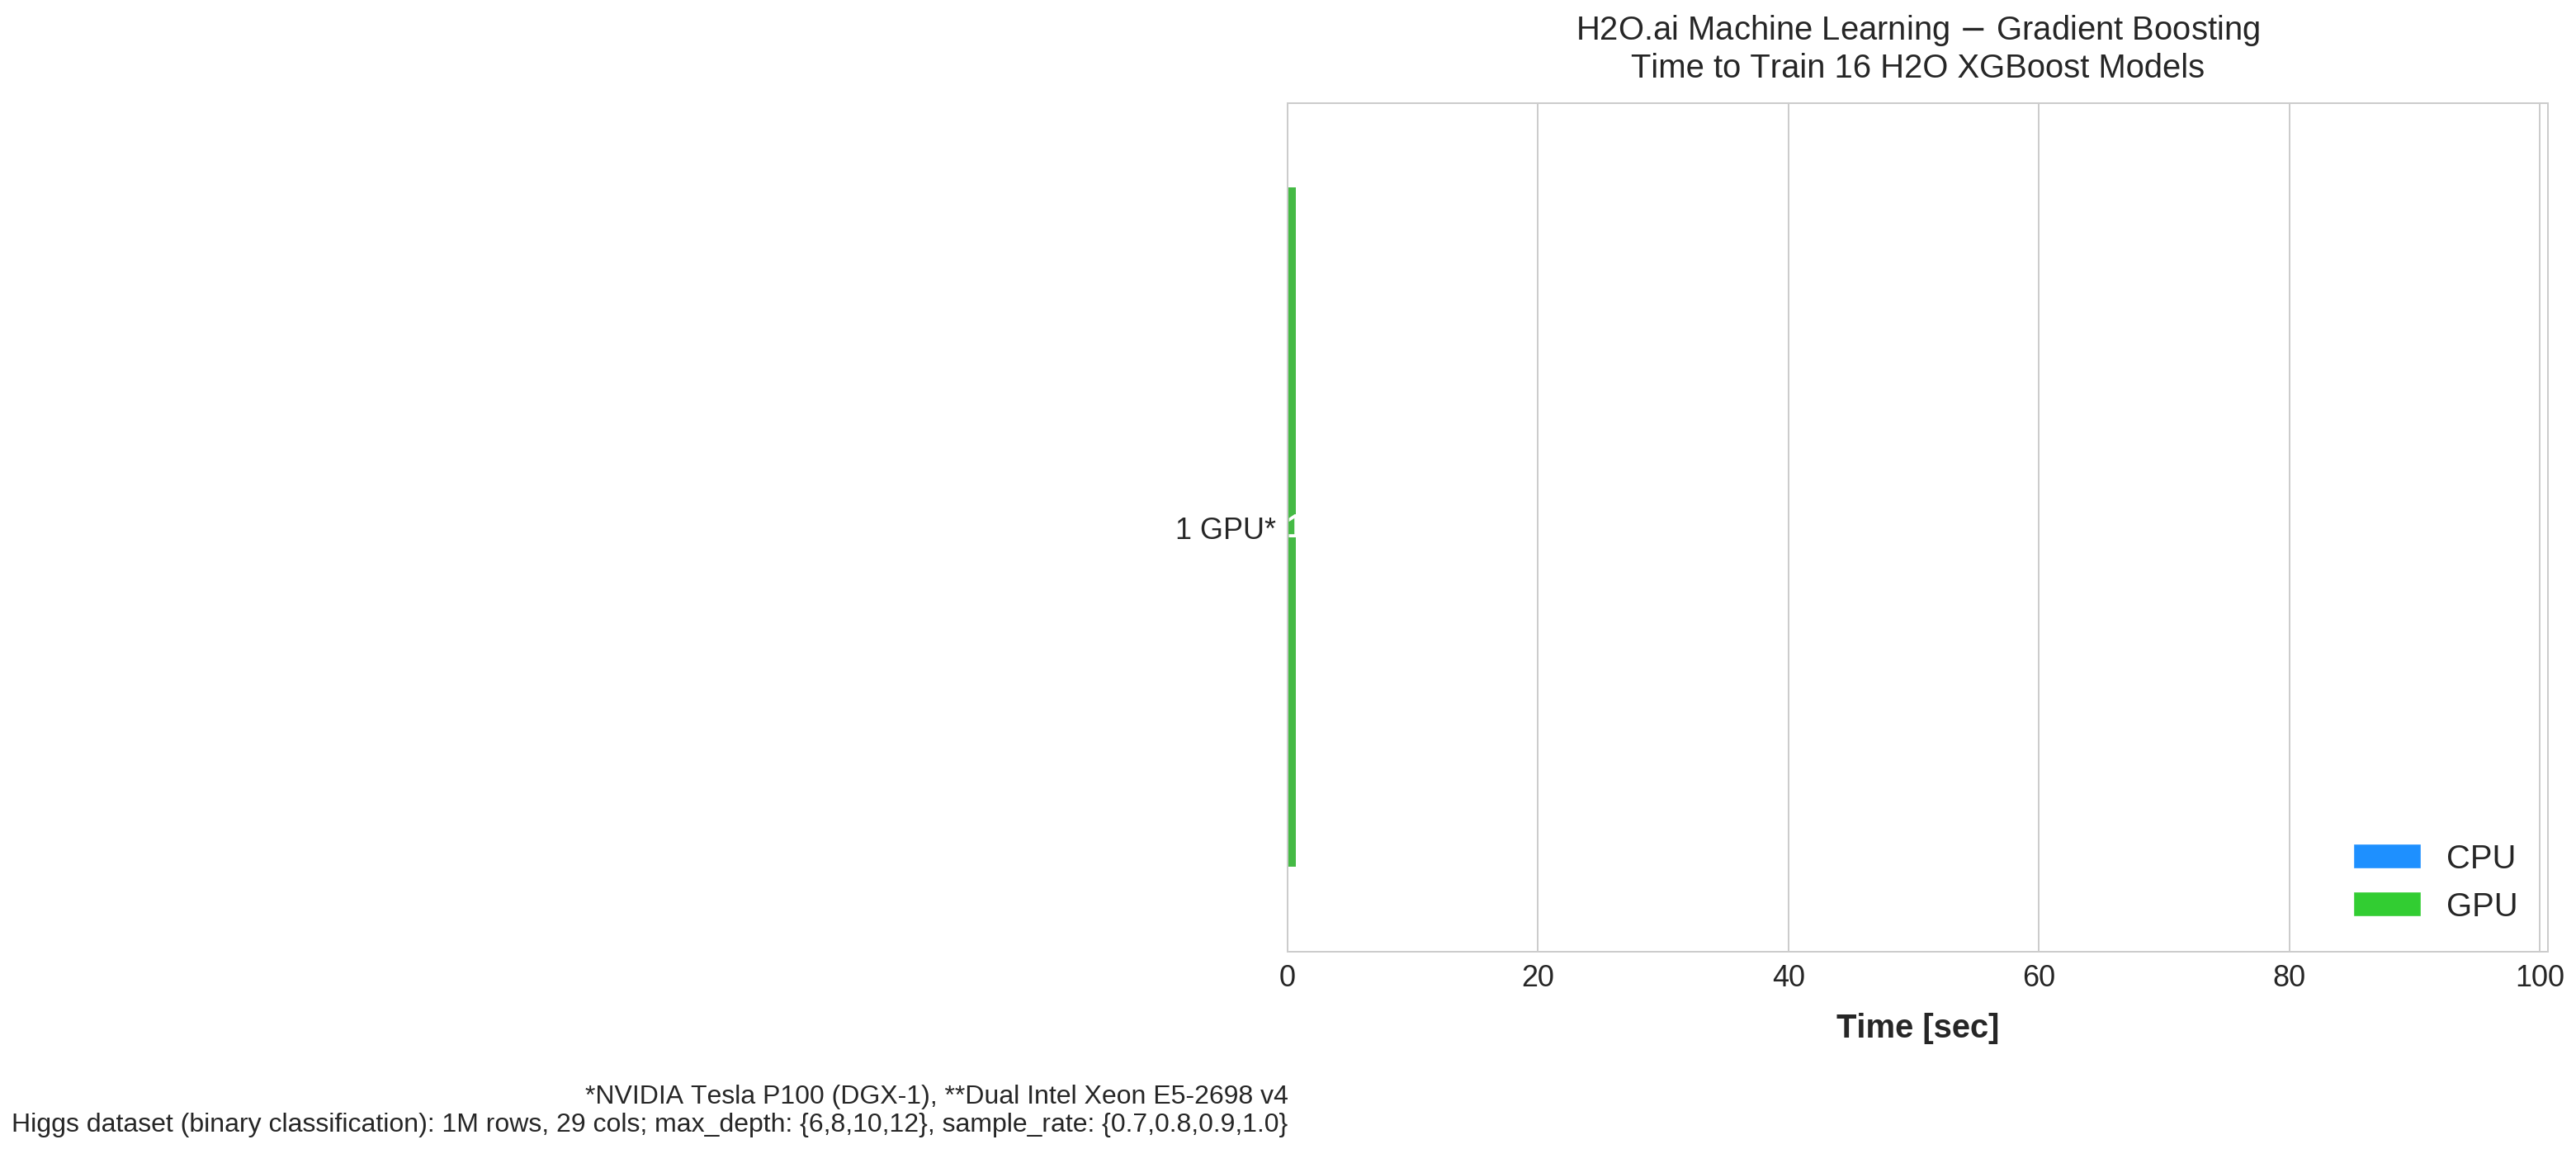

In [7]:
df = pd.DataFrame({'nGPUs':GPU_list, 't_train':times})
label_dic = {'0':'2 CPUs**', '1':'1 GPU*', '2':'2 GPUs*', '4':'4 GPUs*', '8':'8 GPUs*'}
colors = {'gpu':'limegreen', 'cpu':'dodgerblue'}

df['hardware'] = df['nGPUs'].apply(lambda x: str(x))
df = df.replace({'hardware':label_dic})



fig = plt.figure(figsize=(12,9))
ax =sns.barplot(x="t_train", y="hardware", data=df, orient = 'h', 
                 palette = list(df["nGPUs"].apply(lambda x:colors['gpu' if x>0 else 'cpu'])))

title_text = 'H2O.ai Machine Learning $-$ Gradient Boosting\nTime to Train 16 H2O XGBoost Models'
plt.title(title_text, fontsize=20, y=1.02)
plt.xlabel('Time [sec]', fontsize=20, labelpad = 12, fontweight = 'bold')
plt.ylabel('')

ax.yaxis.set_label_position('right')
ax.set_xlim([0,df.t_train.max()+100])
ax.tick_params(labelsize = 18)


for p in ax.patches:
    #print(p)
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[:,1]
    ax.annotate('{:.0f}'.format(x[1]), (x[1]-0.035*df.t_train.max(), y.mean()), 
            ha='center', va='center', fontsize = 20, color = 'w', fontweight = 'bold')

footnote_text=\
"*NVIDIA Tesla P100 (DGX-1), **Dual Intel Xeon E5-2698 v4"\
"\nHiggs dataset (binary classification): 1M rows, 29 cols; max_depth: {6,8,10,12}, sample_rate: {0.7,0.8,0.9,1.0}"
plt.annotate(footnote_text, (0,0), (df.t_train.max()/2, -80), fontsize = 16, xycoords='axes fraction',
             textcoords='offset points', va='top', ha='right')

ax.invert_yaxis()
plt.tight_layout()

green_patch = mpatches.Patch(color='limegreen', label='GPU')
blue_patch = mpatches.Patch(color='dodgerblue', label='CPU')
ax.legend(handles = [blue_patch, green_patch], markerscale = 10, fontsize = 20, loc = 4)